In [77]:
from collections import defaultdict
import get_vpc_corpus
import numpy as np


# Merge any verbs that have the same stem.
VERB_TO_COUNT = defaultdict(int)
for verb, value in get_vpc_corpus.SEED_VERBS.items():
    VERB_TO_COUNT[get_vpc_corpus.get_stem(verb)] += value


def load_vpc_to_year(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year = {}
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            first_occurrence = int(line[3])
            vpc_to_year[curr_vpc] = first_occurrence
    return vpc_to_year


def load_particle_to_count(data_path="vpc_corpus.csv"):
    particle_to_count = defaultdict(int)
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_particle = line[1]
            frequency = int(line[2])
            particle_to_count[curr_particle] += frequency
    return particle_to_count


def normalize_dict(d):
    max_val = np.max(list(d.values()))
    return {k: v / max_val for k, v in d.items()}


PARTICLE_TO_COUNT = normalize_dict(load_particle_to_count())
VERB_TO_COUNT = normalize_dict(VERB_TO_COUNT)
POSSIBLE_VPCS = set([(verb, particle) for verb in VERB_TO_COUNT
                     for particle in PARTICLE_TO_COUNT])
VPC_TO_YEAR = load_vpc_to_year(vpc_vocab=POSSIBLE_VPCS)


In [78]:
from tqdm import tqdm
from collections import defaultdict
import pickle
import get_vpc_corpus


def load_verb_to_year_counts(data_path="verb_counts.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    verb_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            verb = line[0]
            for item in line[3:]:
                year, count = item.split(",")
                verb_to_year_counts[get_vpc_corpus.get_stem(verb)][int(year)] += int(count)
    return verb_to_year_counts


def load_particle_to_year_counts(data_path="vpc_corpus.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    particle_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            curr_particle = line[1]
            for item in line[4:]:
                year, count = item.split(",")
                particle_to_year_counts[curr_particle][int(year)] += int(count)
    return particle_to_year_counts


def load_vpc_to_year_counts(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            for item in line[4:]:
                year, count = item.split(",")
                vpc_to_year_counts[curr_vpc][int(year)] += int(count)
    return vpc_to_year_counts


# VERB_TO_YEAR_COUNTS = load_verb_to_year_counts()
# with open("verb_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(VERB_TO_YEAR_COUNTS), f)

# PARTICLE_TO_YEAR_COUNTS = load_particle_to_year_counts()
# with open("particle_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(PARTICLE_TO_YEAR_COUNTS), f)

# VPC_TO_YEAR_COUNTS = load_vpc_to_year_counts(vpc_vocab=POSSIBLE_VPCS)
# with open("vpc_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(VPC_TO_YEAR_COUNTS), f)


with open("verb_to_year_counts.pickle", "rb") as f:
    VERB_TO_YEAR_COUNTS = pickle.load(f)

with open("particle_to_year_counts.pickle", "rb") as f:
    PARTICLE_TO_YEAR_COUNTS = pickle.load(f)

with open("vpc_to_year_counts.pickle", "rb") as f:
    VPC_TO_YEAR_COUNTS = pickle.load(f)
    

In [79]:
# Frequency-based ranking. -- decade-specific



def get_verb_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return (
        {x: (VERB_TO_YEAR_COUNTS[x[0]].get(year - 10, 0) *
             PARTICLE_TO_YEAR_COUNTS[x[1]].get(year - 10, 0))
         for x in novel_vpcs},
        "Frequency")


def get_verb_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: VERB_TO_YEAR_COUNTS[x[0]].get(year - 10, 0)
            for x in novel_vpcs}, "Verb Frequency")


def get_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: PARTICLE_TO_YEAR_COUNTS[x[1]].get(year - 10, 0)
            for x in novel_vpcs}, "Prt Frequency")


def get_verb_in_vpc_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    verb_to_n_vpcs = defaultdict(int)
    for curr_verb, _ in known_vpcs:
        verb_to_n_vpcs[curr_verb] += 1
    return ({x: verb_to_n_vpcs[x[0]]
            for x in novel_vpcs},
            "VPC count")


In [81]:
# Neighbor-based ranking.


import pickle
import numpy as np
from tqdm import trange, tqdm
from sklearn.metrics.pairwise import cosine_similarity


def build_mini_verb_dataset(
        start_decade=1800, end_decade=2000, output_path="verb_vectors"):
    # find all vectors for verbs in VERB_TO_COUNT
    # write them to output_path
    for year in trange(start_decade, end_decade, 10):
        with open(f"sgns/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        curr_vectors = np.load(f"sgns/{year}-w.npy")
        verb_vocab = [item for item in curr_vocab if item in VERB_TO_COUNT]
        verb_embeddings = np.array([
            curr_vectors[i] for i, label in enumerate(curr_vocab)
            if label in VERB_TO_COUNT
        ])
        with open(f"verb_vectors/{year}-vocab.pkl", "wb") as f:
            pickle.dump(verb_vocab, f)
        np.save(f"verb_vectors/{year}-w.npy", verb_embeddings)


def compute_nearest_vpc_verbs_prototype(
        start_decade=1810, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # prev_decade_vpcs = set([
        #     curr_vpc for curr_vpc, curr_year_counts in VPC_TO_YEAR_COUNTS.items()
        #     if curr_year_counts[year - 10] > 0])
        
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year - 10}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year - 10}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            # for v, prt in prev_decade_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = np.array([
            np.mean([
                curr_vectors[verb_to_idx[verb]]
                for verb in prt_to_verbs[particle]
                if verb in verb_to_idx], axis=0) 
            for particle in particles])
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            prt_vec = particle_vectors[particle_to_idx[curr_prt]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = cosine_similarity(
                [verb_vec], [prt_vec])[0][0]

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking(
        known_vpcs, year, data_path="nearest_neighbors_prototype.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Semantic prototype")


# build_mini_verb_dataset()
# compute_nearest_vpc_verbs_prototype()

In [82]:
def compute_nearest_vpc_verbs_exemplar(
        start_decade=1810, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # prev_decade_vpcs = set([
        #     curr_vpc for curr_vpc, curr_year_counts in VPC_TO_YEAR_COUNTS.items()
        #     if curr_year_counts[year - 10] > 0])
        
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year - 10}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year - 10}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            # for v, prt in prev_decade_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = {particle: np.array(
            [curr_vectors[verb_to_idx[verb]]
             for verb in prt_to_verbs[particle]
             if verb in verb_to_idx])
            for particle in particles}
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = np.max(cosine_similarity(
                [verb_vec], particle_vectors[curr_prt]))

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking_exemplar(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Semantic exemplar")


# compute_nearest_vpc_verbs_exemplar()

In [6]:
with open("levin_1993_data.p", "rb") as f: 
    LEVIN_VERBS = pickle.load(f)[0]
    LEVIN_VERBS = {k: set(v) for k, v in LEVIN_VERBS.items()}
LEVIN_VERB_LIST = list(LEVIN_VERBS.keys())
LEVIN_VERB_TO_IDX = {v: i for i, v in enumerate(LEVIN_VERB_LIST)}
LEVIN_DISTANCES = np.array([[
    len(LEVIN_VERBS[verb1].intersection(LEVIN_VERBS[verb2])) /
    len(LEVIN_VERBS[verb1].union(LEVIN_VERBS[verb2]))
    for verb1 in LEVIN_VERB_LIST]
    for verb2 in LEVIN_VERB_LIST])


def get_ranking_levin_verbs(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):    
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    prt_to_verbs = defaultdict(set)
    for v, prt in known_vpcs:
        prt_to_verbs[prt].add(v)
    
    return ({x: np.max([
            LEVIN_DISTANCES[LEVIN_VERB_TO_IDX[verb], LEVIN_VERB_TO_IDX[x[0]]]
            for verb in prt_to_verbs[x[1]]
            if verb in LEVIN_VERBS]) if x[0] in LEVIN_VERBS else 0
            for x in novel_vpcs},
            "Levin verbs exemplar")

In [83]:
# Phonological neighbor-based ranking

from tqdm import tqdm, trange
import Levenshtein
import pickle


def compute_nearest_vpc_verbs_phonological_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            mean_sim = np.mean([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = mean_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)
        
        
def compute_nearest_vpc_verbs_phonological_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            max_sim = np.max([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = max_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_phonological_neighbor_ranking(
        known_vpcs, year,
        data_path="phonological_nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year][x]
            for x in novel_vpcs},
            "Phonological exemplar")

        
#compute_nearest_vpc_verbs_phonological_prototype()
#compute_nearest_vpc_verbs_phonological_exemplar()



  0%|          | 0/101 [00:00<?, ?it/s]

 48%|████▊     | 48/101 [00:00<00:00, 476.95it/s]

 64%|██████▍   | 65/101 [00:00<00:00, 303.92it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 196.94it/s]

 93%|█████████▎| 94/101 [00:00<00:00, 147.58it/s]

100%|██████████| 101/101 [00:00<00:00, 171.36it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 44%|████▎     | 44/101 [00:00<00:00, 431.86it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 254.23it/s]

 69%|██████▉   | 70/101 [00:00<00:00, 183.36it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 142.48it/s]

 94%|█████████▍| 95/101 [00:00<00:00, 113.62it/s]

100%|██████████| 101/101 [00:00<00:00, 142.17it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 50%|█████     | 51/101 [00:00<00:00, 501.69it/s]

 66%|██████▋   | 67/101 [00:00<00:00, 289.65it/s]

 81%|████████  | 82/101 [00:00<00:00, 178.26it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 132.19it/s]

100%|██████████| 101/101 [00:00<00:00, 161.39it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 48%|████▊     

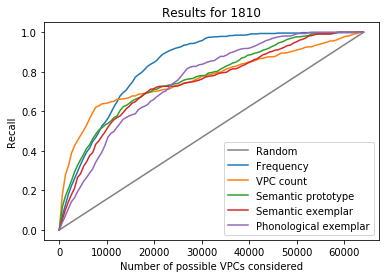



  0%|          | 0/101 [00:00<?, ?it/s]

 50%|█████     | 51/101 [00:00<00:00, 489.07it/s]

 65%|██████▌   | 66/101 [00:00<00:00, 231.43it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 137.07it/s]

 91%|█████████ | 92/101 [00:00<00:00, 110.56it/s]

100%|██████████| 101/101 [00:00<00:00, 141.13it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 47%|████▋     | 47/101 [00:00<00:00, 467.37it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 296.17it/s]

 77%|███████▋  | 78/101 [00:00<00:00, 186.34it/s]

 91%|█████████ | 92/101 [00:00<00:00, 144.00it/s]

100%|██████████| 101/101 [00:00<00:00, 165.69it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 46%|████▌     | 46/101 [00:00<00:00, 438.85it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 256.02it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 167.99it/s]

 85%|████████▌ | 86/101 [00:00<00:00, 127.83it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 104.95it/s]

100%|██████████| 101/101 [00:00<00:00, 141.95it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 38%|███▊      

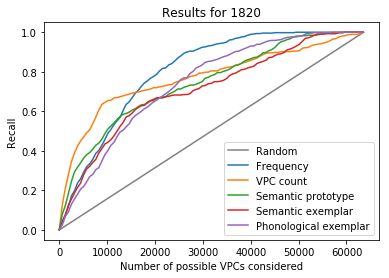



  0%|          | 0/101 [00:00<?, ?it/s]

 44%|████▎     | 44/101 [00:00<00:00, 432.83it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 284.44it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 176.71it/s]

 86%|████████▌ | 87/101 [00:00<00:00, 128.51it/s]

 98%|█████████▊| 99/101 [00:00<00:00, 100.47it/s]

100%|██████████| 101/101 [00:00<00:00, 133.60it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 50%|█████     | 51/101 [00:00<00:00, 491.26it/s]

 68%|██████▊   | 69/101 [00:00<00:00, 318.17it/s]

 84%|████████▍ | 85/101 [00:00<00:00, 217.07it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 137.66it/s]

100%|██████████| 101/101 [00:00<00:00, 171.39it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 39%|███▊      | 39/101 [00:00<00:00, 385.36it/s]

 54%|█████▍    | 55/101 [00:00<00:00, 254.34it/s]

 68%|██████▊   | 69/101 [00:00<00:00, 195.20it/s]

 81%|████████  | 82/101 [00:00<00:00, 153.11it/s]

 93%|█████████▎| 94/101 [00:00<00:00, 121.32it/s]

100%|██████████| 101/101 [00:00<00:00, 146.64it/s]

  0%

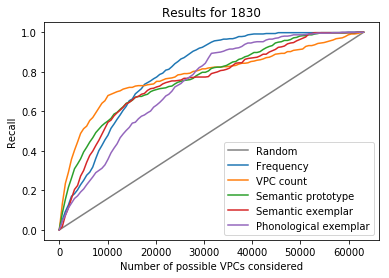



  0%|          | 0/101 [00:00<?, ?it/s]

 47%|████▋     | 47/101 [00:00<00:00, 445.40it/s]

 60%|██████    | 61/101 [00:00<00:00, 230.64it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 155.96it/s]

 85%|████████▌ | 86/101 [00:00<00:00, 120.75it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 100.92it/s]

100%|██████████| 101/101 [00:00<00:00, 133.86it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 47%|████▋     | 47/101 [00:00<00:00, 450.21it/s]

 60%|██████    | 61/101 [00:00<00:00, 240.03it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 156.40it/s]

 85%|████████▌ | 86/101 [00:00<00:00, 119.55it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 94.16it/s] 

100%|██████████| 101/101 [00:00<00:00, 117.08it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 43%|████▎     | 43/101 [00:00<00:00, 428.76it/s]

 57%|█████▋    | 58/101 [00:00<00:00, 273.38it/s]

 71%|███████▏  | 72/101 [00:00<00:00, 192.29it/s]

 84%|████████▍ | 85/101 [00:00<00:00, 144.87it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 120.63it/s]

100%|█

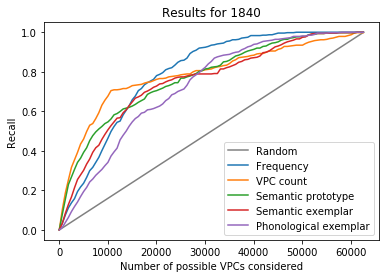



  0%|          | 0/101 [00:00<?, ?it/s]

 53%|█████▎    | 54/101 [00:00<00:00, 520.68it/s]

 69%|██████▉   | 70/101 [00:00<00:00, 287.85it/s]

 85%|████████▌ | 86/101 [00:00<00:00, 196.97it/s]

100%|██████████| 101/101 [00:00<00:00, 151.11it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 560.05it/s]

 74%|███████▍  | 75/101 [00:00<00:00, 341.86it/s]

 92%|█████████▏| 93/101 [00:00<00:00, 224.96it/s]

100%|██████████| 101/101 [00:00<00:00, 225.60it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 556.64it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 321.90it/s]

 90%|█████████ | 91/101 [00:00<00:00, 234.03it/s]

100%|██████████| 101/101 [00:00<00:00, 244.26it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 57%|█████▋    | 58/101 [00:00<00:00, 578.15it/s]

 75%|███████▌  | 76/101 [00:00<00:00, 343.10it/s]

 93%|█████████▎| 94/101 [00:00<00:00, 235.96it/s]

100%|██████████| 101/101 [00:00<00:00, 249.86it/s]

  0%|       

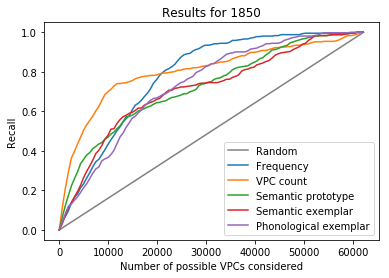



  0%|          | 0/101 [00:00<?, ?it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 550.95it/s]

 75%|███████▌  | 76/101 [00:00<00:00, 341.49it/s]

 92%|█████████▏| 93/101 [00:00<00:00, 240.41it/s]

100%|██████████| 101/101 [00:00<00:00, 253.69it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 51%|█████▏    | 52/101 [00:00<00:00, 516.72it/s]

 68%|██████▊   | 69/101 [00:00<00:00, 313.51it/s]

 84%|████████▍ | 85/101 [00:00<00:00, 204.71it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 156.69it/s]

100%|██████████| 101/101 [00:00<00:00, 196.42it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 551.78it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 323.64it/s]

 90%|█████████ | 91/101 [00:00<00:00, 199.55it/s]

100%|██████████| 101/101 [00:00<00:00, 213.17it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 586.73it/s]

 77%|███████▋  | 78/101 [00:00<00:00, 333.37it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 202.82it/s]

100%|█████████

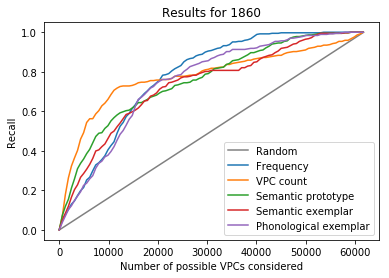



  0%|          | 0/101 [00:00<?, ?it/s]

 56%|█████▋    | 57/101 [00:00<00:00, 552.12it/s]

 73%|███████▎  | 74/101 [00:00<00:00, 290.03it/s]

 89%|████████▉ | 90/101 [00:00<00:00, 203.00it/s]

100%|██████████| 101/101 [00:00<00:00, 214.13it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 48%|████▊     | 48/101 [00:00<00:00, 475.21it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 285.19it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 175.09it/s]

 91%|█████████ | 92/101 [00:00<00:00, 127.07it/s]

100%|██████████| 101/101 [00:00<00:00, 148.48it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 46%|████▌     | 46/101 [00:00<00:00, 445.80it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 222.73it/s]

 72%|███████▏  | 73/101 [00:00<00:00, 146.09it/s]

 84%|████████▍ | 85/101 [00:00<00:00, 120.22it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 101.02it/s]

100%|██████████| 101/101 [00:00<00:00, 127.62it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 52%|█████▏    | 53/101 [00:00<00:00, 515.29it/s]

 68%|██████▊   

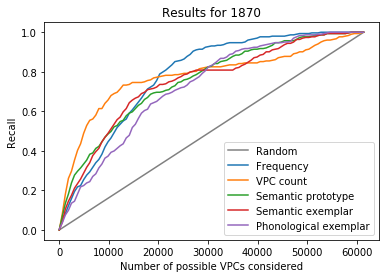



  0%|          | 0/101 [00:00<?, ?it/s]

 57%|█████▋    | 58/101 [00:00<00:00, 564.54it/s]

 74%|███████▍  | 75/101 [00:00<00:00, 265.62it/s]

 90%|█████████ | 91/101 [00:00<00:00, 165.50it/s]

100%|██████████| 101/101 [00:00<00:00, 180.17it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 42%|████▏     | 42/101 [00:00<00:00, 408.29it/s]

 54%|█████▍    | 55/101 [00:00<00:00, 222.49it/s]

 66%|██████▋   | 67/101 [00:00<00:00, 132.28it/s]

 77%|███████▋  | 78/101 [00:00<00:00, 111.54it/s]

 87%|████████▋ | 88/101 [00:00<00:00, 94.21it/s] 

 96%|█████████▌| 97/101 [00:00<00:00, 87.49it/s]

100%|██████████| 101/101 [00:00<00:00, 111.79it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 603.99it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 336.42it/s]

 97%|█████████▋| 98/101 [00:00<00:00, 229.66it/s]

100%|██████████| 101/101 [00:00<00:00, 261.87it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 625.73it/s]

 81%|████████  |

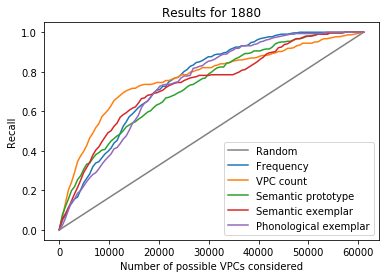



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 620.21it/s]

 81%|████████  | 82/101 [00:00<00:00, 342.22it/s]

100%|██████████| 101/101 [00:00<00:00, 232.15it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 58%|█████▊    | 59/101 [00:00<00:00, 580.59it/s]

 76%|███████▌  | 77/101 [00:00<00:00, 345.86it/s]

 94%|█████████▍| 95/101 [00:00<00:00, 238.74it/s]

100%|██████████| 101/101 [00:00<00:00, 256.45it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 595.72it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 348.97it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 250.13it/s]

100%|██████████| 101/101 [00:00<00:00, 279.28it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 626.41it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 347.62it/s]

100%|██████████| 101/101 [00:00<00:00, 281.82it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 598.85it/s]

 77%|███████▋  | 78/10

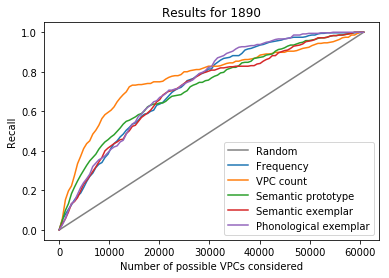



  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 583.28it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 355.21it/s]

 97%|█████████▋| 98/101 [00:00<00:00, 236.10it/s]

100%|██████████| 101/101 [00:00<00:00, 271.85it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 597.99it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 352.03it/s]

 97%|█████████▋| 98/101 [00:00<00:00, 244.96it/s]

100%|██████████| 101/101 [00:00<00:00, 280.16it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 57%|█████▋    | 58/101 [00:00<00:00, 578.64it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 375.87it/s]

 97%|█████████▋| 98/101 [00:00<00:00, 255.26it/s]

100%|██████████| 101/101 [00:00<00:00, 274.51it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 617.48it/s]

 81%|████████  | 82/101 [00:00<00:00, 362.42it/s]

100%|██████████| 101/101 [00:00<00:00, 236.60it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/10

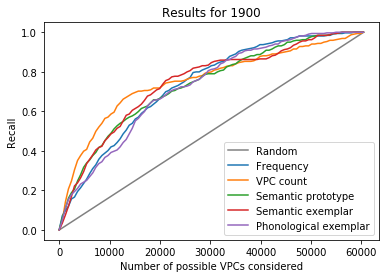



  0%|          | 0/101 [00:00<?, ?it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 592.67it/s]

 77%|███████▋  | 78/101 [00:00<00:00, 334.98it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 213.96it/s]

100%|██████████| 101/101 [00:00<00:00, 239.87it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 58%|█████▊    | 59/101 [00:00<00:00, 581.17it/s]

 76%|███████▌  | 77/101 [00:00<00:00, 319.29it/s]

 93%|█████████▎| 94/101 [00:00<00:00, 222.55it/s]

100%|██████████| 101/101 [00:00<00:00, 237.48it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 57%|█████▋    | 58/101 [00:00<00:00, 564.55it/s]

 76%|███████▌  | 77/101 [00:00<00:00, 346.30it/s]

 94%|█████████▍| 95/101 [00:00<00:00, 236.00it/s]

100%|██████████| 101/101 [00:00<00:00, 253.25it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 64%|██████▍   | 65/101 [00:00<00:00, 626.46it/s]

 83%|████████▎ | 84/101 [00:00<00:00, 336.54it/s]

100%|██████████| 101/101 [00:00<00:00, 281.66it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 

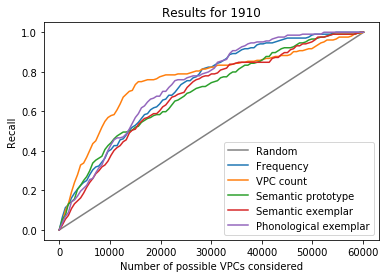



  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 635.56it/s]

 83%|████████▎ | 84/101 [00:00<00:00, 347.19it/s]

100%|██████████| 101/101 [00:00<00:00, 284.62it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 624.86it/s]

 81%|████████  | 82/101 [00:00<00:00, 351.42it/s]

100%|██████████| 101/101 [00:00<00:00, 229.87it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 607.10it/s]

 81%|████████  | 82/101 [00:00<00:00, 357.89it/s]

100%|██████████| 101/101 [00:00<00:00, 240.98it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 607.07it/s]

 81%|████████  | 82/101 [00:00<00:00, 362.56it/s]

100%|██████████| 101/101 [00:00<00:00, 252.90it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 588.59it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 353.57it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 226.01it/s]

100%|██████████| 1

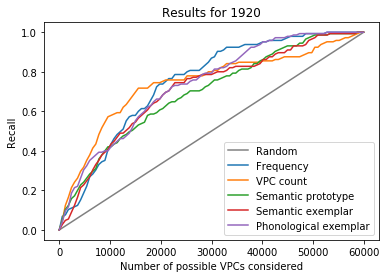



  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 627.59it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 339.84it/s]

100%|██████████| 101/101 [00:00<00:00, 280.76it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 620.39it/s]

 81%|████████  | 82/101 [00:00<00:00, 355.83it/s]

100%|██████████| 101/101 [00:00<00:00, 234.28it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 632.65it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 367.28it/s]

100%|██████████| 101/101 [00:00<00:00, 298.62it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 607.89it/s]

 81%|████████  | 82/101 [00:00<00:00, 359.50it/s]

100%|██████████| 101/101 [00:00<00:00, 253.26it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 608.83it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 366.84it/s]

100%|██████████| 101/101 [00:00<00:00, 287.04it/s]

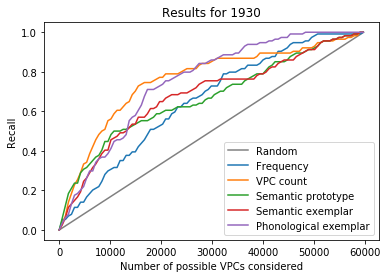



  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 609.49it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 364.62it/s]

 98%|█████████▊| 99/101 [00:00<00:00, 242.51it/s]

100%|██████████| 101/101 [00:00<00:00, 276.37it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 616.60it/s]

 80%|████████  | 81/101 [00:00<00:00, 354.00it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 243.04it/s]

100%|██████████| 101/101 [00:00<00:00, 282.01it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 618.23it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 344.50it/s]

100%|██████████| 101/101 [00:00<00:00, 279.56it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 636.00it/s]

 83%|████████▎ | 84/101 [00:00<00:00, 376.96it/s]

100%|██████████| 101/101 [00:00<00:00, 315.52it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 623.30it/s]

 81%|████████  | 82/101

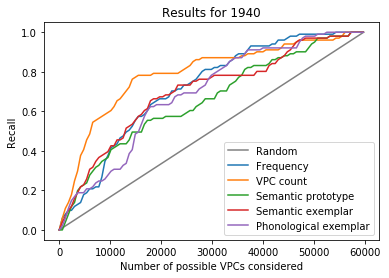



  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 607.35it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 351.58it/s]

 98%|█████████▊| 99/101 [00:00<00:00, 236.12it/s]

100%|██████████| 101/101 [00:00<00:00, 272.69it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 625.98it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 359.40it/s]

100%|██████████| 101/101 [00:00<00:00, 290.47it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 624.37it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 339.03it/s]

100%|██████████| 101/101 [00:00<00:00, 289.17it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 626.30it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 360.19it/s]

100%|██████████| 101/101 [00:00<00:00, 303.38it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 605.23it/s]

 81%|████████  | 82/101 [00:00<00:00, 374.68it/s]

100%|██████████| 101/101

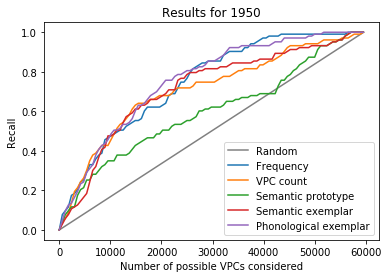



  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 608.39it/s]

 81%|████████  | 82/101 [00:00<00:00, 316.18it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 216.84it/s]

100%|██████████| 101/101 [00:00<00:00, 257.10it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 627.72it/s]

 82%|████████▏ | 83/101 [00:00<00:00, 341.65it/s]

100%|██████████| 101/101 [00:00<00:00, 280.55it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 64%|██████▍   | 65/101 [00:00<00:00, 643.00it/s]

 84%|████████▍ | 85/101 [00:00<00:00, 377.87it/s]

100%|██████████| 101/101 [00:00<00:00, 326.50it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 55%|█████▌    | 56/101 [00:00<00:00, 532.96it/s]

 71%|███████▏  | 72/101 [00:00<00:00, 271.87it/s]

 86%|████████▌ | 87/101 [00:00<00:00, 191.81it/s]

100%|██████████| 101/101 [00:00<00:00, 162.34it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 624.77it/s]

 83%|████████▎ | 84/1

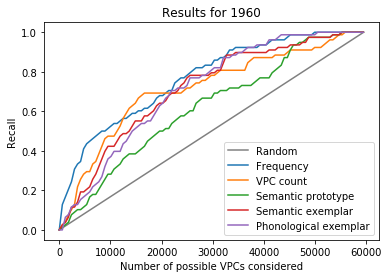



  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 595.43it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 301.36it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 215.39it/s]

100%|██████████| 101/101 [00:00<00:00, 236.72it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 604.06it/s]

 80%|████████  | 81/101 [00:00<00:00, 354.21it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 243.90it/s]

100%|██████████| 101/101 [00:00<00:00, 281.14it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 59%|█████▉    | 60/101 [00:00<00:00, 583.55it/s]

 79%|███████▉  | 80/101 [00:00<00:00, 360.44it/s]

 97%|█████████▋| 98/101 [00:00<00:00, 243.11it/s]

100%|██████████| 101/101 [00:00<00:00, 269.93it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 619.87it/s]

 80%|████████  | 81/101 [00:00<00:00, 362.45it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 239.18it/s]

100%|██████████| 101/101 [00:00<00:00, 274.90it/s]

  0%|       

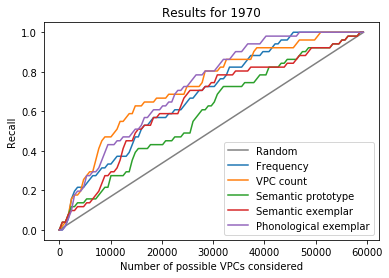



  0%|          | 0/101 [00:00<?, ?it/s]

 58%|█████▊    | 59/101 [00:00<00:00, 581.92it/s]

 76%|███████▌  | 77/101 [00:00<00:00, 303.04it/s]

 93%|█████████▎| 94/101 [00:00<00:00, 200.13it/s]

100%|██████████| 101/101 [00:00<00:00, 225.36it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 58%|█████▊    | 59/101 [00:00<00:00, 567.33it/s]

 77%|███████▋  | 78/101 [00:00<00:00, 355.13it/s]

 95%|█████████▌| 96/101 [00:00<00:00, 236.00it/s]

100%|██████████| 101/101 [00:00<00:00, 257.33it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 61%|██████▏   | 62/101 [00:00<00:00, 617.01it/s]

 80%|████████  | 81/101 [00:00<00:00, 358.43it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 240.44it/s]

100%|██████████| 101/101 [00:00<00:00, 279.17it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 63%|██████▎   | 64/101 [00:00<00:00, 636.67it/s]

 83%|████████▎ | 84/101 [00:00<00:00, 367.32it/s]

100%|██████████| 101/101 [00:00<00:00, 293.00it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 51%|█████▏    | 52/101

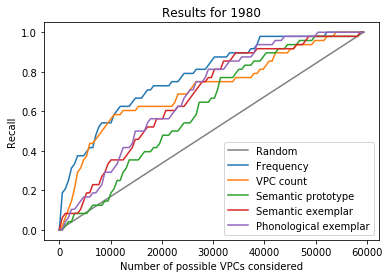



  0%|          | 0/101 [00:00<?, ?it/s]

 60%|██████    | 61/101 [00:00<00:00, 596.89it/s]

 78%|███████▊  | 79/101 [00:00<00:00, 347.43it/s]

 96%|█████████▌| 97/101 [00:00<00:00, 223.74it/s]

100%|██████████| 101/101 [00:00<00:00, 259.90it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 609.58it/s]

 81%|████████  | 82/101 [00:00<00:00, 329.51it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 238.84it/s]

100%|██████████| 101/101 [00:00<00:00, 279.28it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 62%|██████▏   | 63/101 [00:00<00:00, 625.90it/s]

 81%|████████  | 82/101 [00:00<00:00, 351.11it/s]

100%|██████████| 101/101 [00:00<00:00, 233.63it/s]



  0%|          | 0/101 [00:00<?, ?it/s]

 64%|██████▍   | 65/101 [00:00<00:00, 629.81it/s]

 83%|████████▎ | 84/101 [00:00<00:00, 366.22it/s]

100%|██████████| 101/101 [00:00<00:00, 315.67it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

 66%|██████▋   | 67/101 [00:00<00:00, 647.65it/s]

 86%|████████▌ | 87/1

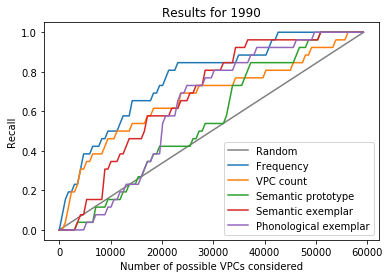

In [84]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_vpcs(novel_vpcs, ranking, ranking_name=None):
    for item in novel_vpcs:
        assert item in ranking, f"{item} not in ranking"
    n_vpcs = list(range(1, len(ranking), len(ranking) // 100))
    recall = []
    for i in tqdm(n_vpcs):
        curr_n_correct = len([item for item in ranking[:i] if item in novel_vpcs])
        recall.append(curr_n_correct / len(novel_vpcs))
    plt.plot(n_vpcs, recall, label=ranking_name)
    
    
def get_rank_list(word_to_score):
    words = list(word_to_score.keys())
    return sorted(words, key=lambda x: word_to_score[x], reverse=True)

    
def run_experiment(ranking_functions, start_decade=1810, end_decade=2000, save_figures=False):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    for year in range(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        plt.plot([0, len(POSSIBLE_VPCS) - len(known_vpcs)], [0, 1], label="Random", color="gray")
        for ranking_function in ranking_functions:
            ranking, ranking_name = ranking_function(known_vpcs, year)
            ranking = get_rank_list(ranking)
            evaluate_vpcs(novel_vpcs, ranking, ranking_name=ranking_name)    
        plt.xlabel("Number of possible VPCs considered")
        plt.ylabel("Recall")
        plt.legend()
        plt.title(f"Results for {year}")
        if save_figures:
            plt.savefig(f"ROC_curves_{year}.png", dpi=500)
        plt.show()
        known_vpcs.update(novel_vpcs)


run_experiment(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking], save_figures=True)

100%|██████████| 101/101 [00:00<00:00, 186.00it/s]


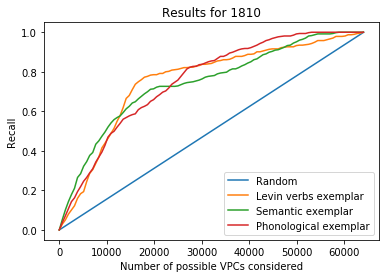

100%|██████████| 101/101 [00:00<00:00, 219.51it/s]


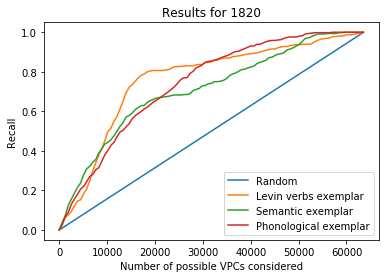

100%|██████████| 101/101 [00:00<00:00, 191.58it/s]


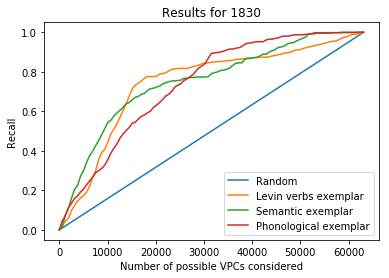

100%|██████████| 101/101 [00:00<00:00, 162.19it/s]


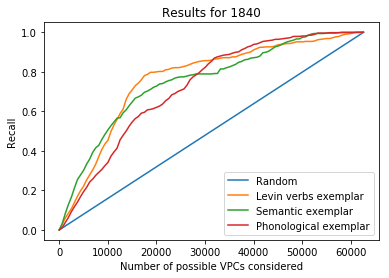

100%|██████████| 101/101 [00:00<00:00, 208.75it/s]


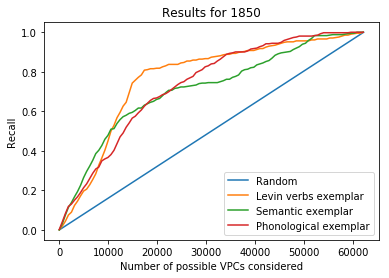

100%|██████████| 101/101 [00:00<00:00, 219.81it/s]


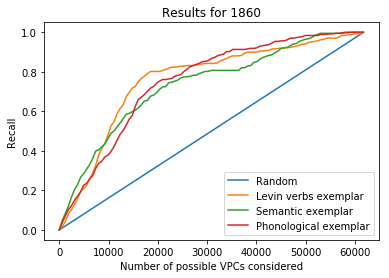

100%|██████████| 101/101 [00:00<00:00, 210.57it/s]


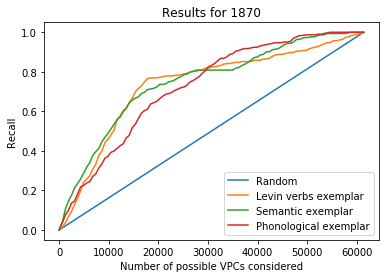

100%|██████████| 101/101 [00:00<00:00, 241.63it/s]


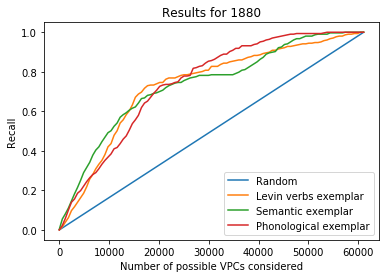

100%|██████████| 101/101 [00:00<00:00, 214.44it/s]


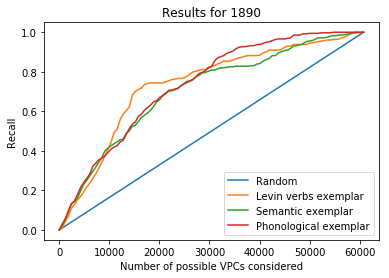

100%|██████████| 101/101 [00:00<00:00, 213.89it/s]


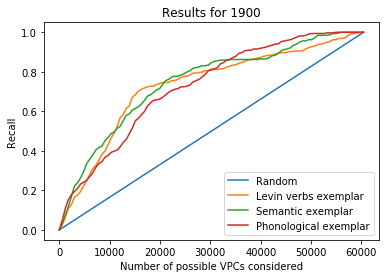

100%|██████████| 101/101 [00:00<00:00, 235.47it/s]


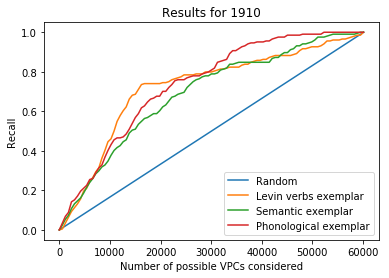

100%|██████████| 101/101 [00:00<00:00, 296.17it/s]


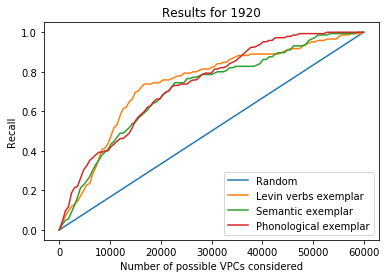

100%|██████████| 101/101 [00:00<00:00, 187.72it/s]


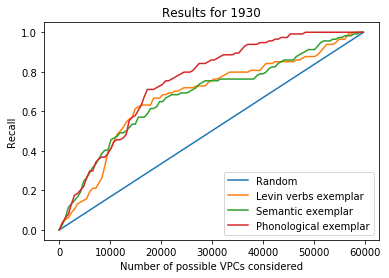

100%|██████████| 101/101 [00:00<00:00, 322.25it/s]


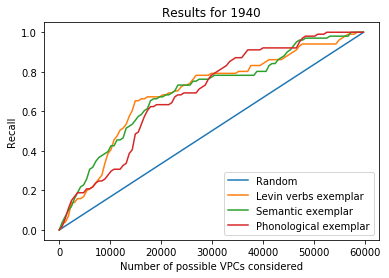

100%|██████████| 101/101 [00:00<00:00, 245.73it/s]


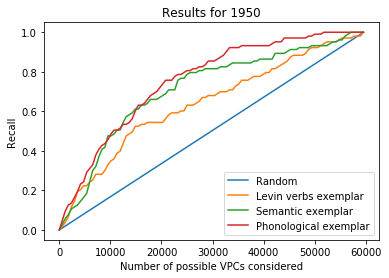

100%|██████████| 101/101 [00:00<00:00, 184.65it/s]


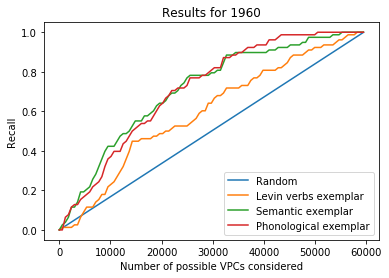

100%|██████████| 101/101 [00:00<00:00, 302.24it/s]


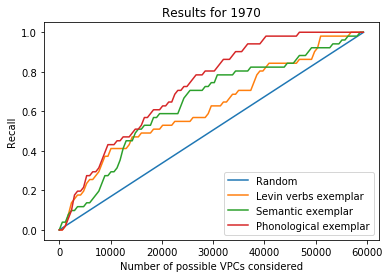

100%|██████████| 101/101 [00:00<00:00, 301.88it/s]


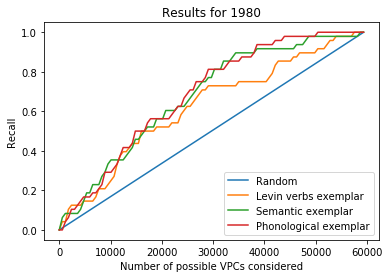

In [10]:
# TODO: In order to have a fair evaluation of the levin verbs method,
# we would need to limit the predictions of the other exemplar methods
# to only select from among levin verbs.

run_experiment(
    [get_ranking_levin_verbs,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking])

100%|██████████| 101/101 [00:00<00:00, 217.32it/s]


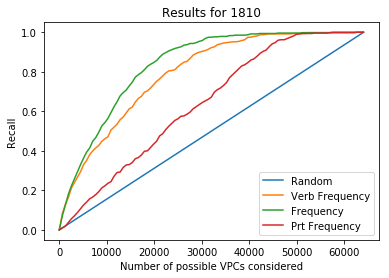

100%|██████████| 101/101 [00:00<00:00, 231.52it/s]


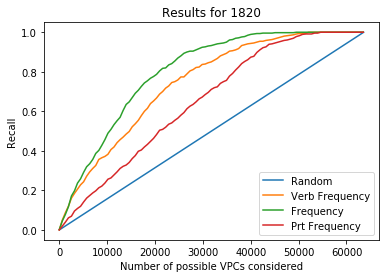

100%|██████████| 101/101 [00:00<00:00, 249.25it/s]


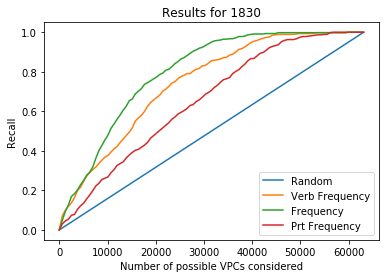

100%|██████████| 101/101 [00:00<00:00, 234.26it/s]


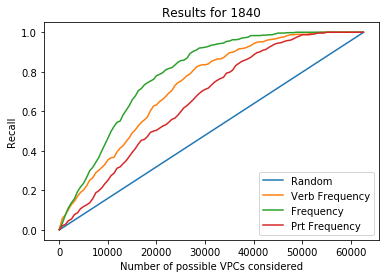

100%|██████████| 101/101 [00:00<00:00, 258.97it/s]


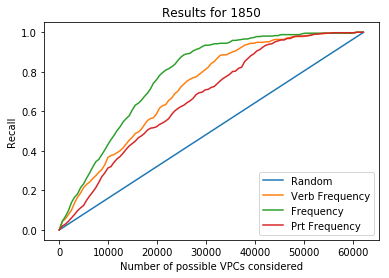

100%|██████████| 101/101 [00:00<00:00, 239.78it/s]


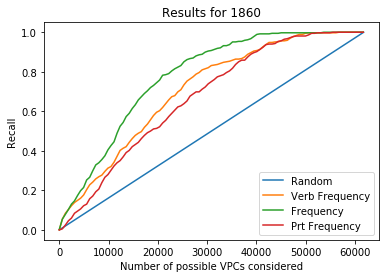

100%|██████████| 101/101 [00:00<00:00, 219.27it/s]


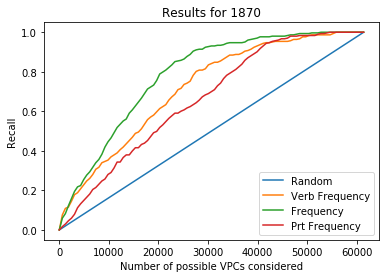

100%|██████████| 101/101 [00:00<00:00, 260.21it/s]


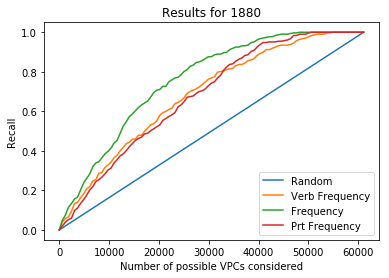

100%|██████████| 101/101 [00:00<00:00, 266.02it/s]


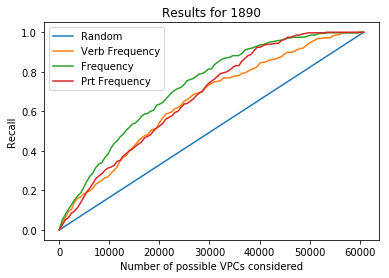

100%|██████████| 101/101 [00:00<00:00, 218.86it/s]


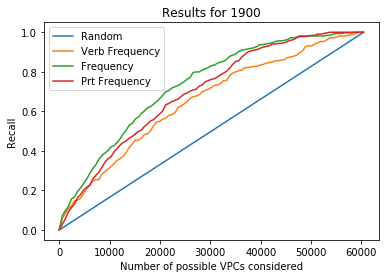

100%|██████████| 101/101 [00:00<00:00, 264.67it/s]


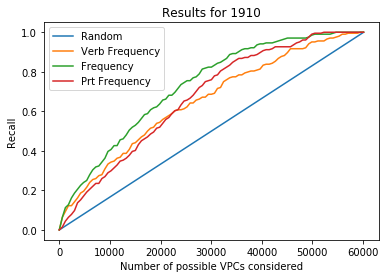

100%|██████████| 101/101 [00:00<00:00, 255.67it/s]


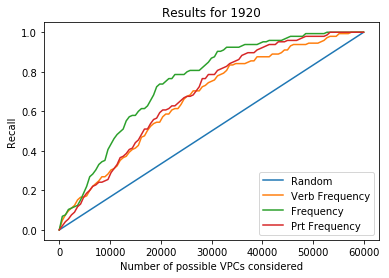

100%|██████████| 101/101 [00:00<00:00, 263.82it/s]


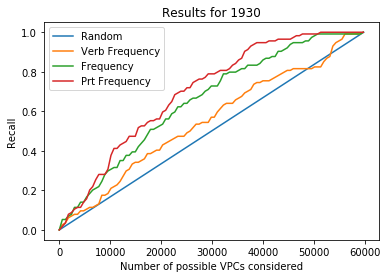

100%|██████████| 101/101 [00:00<00:00, 226.47it/s]


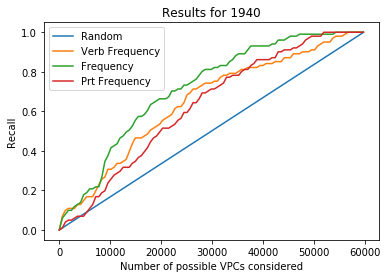

100%|██████████| 101/101 [00:00<00:00, 220.73it/s]


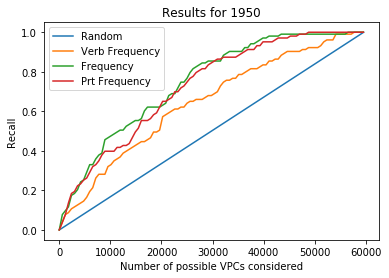

100%|██████████| 101/101 [00:00<00:00, 221.91it/s]


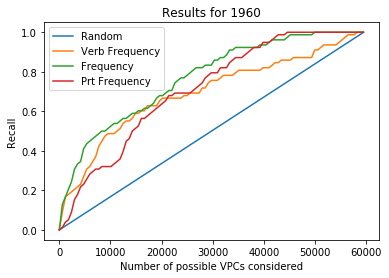

100%|██████████| 101/101 [00:00<00:00, 258.75it/s]


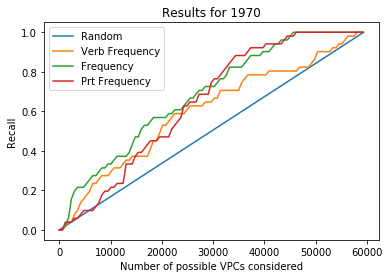

100%|██████████| 101/101 [00:00<00:00, 238.74it/s]


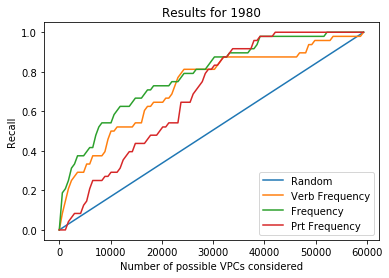

In [11]:
run_experiment(
    [get_verb_frequency_ranking,
     get_verb_particle_frequency_ranking,
     get_particle_frequency_ranking])

# Feature correlations

In [15]:
import scipy.stats
import seaborn as sns


def plot_feature_correlations(
        ranking_functions, start_decade=1810, end_decade=2000,
        plot_style="by_year"  # in {"by_year", "heatmap"}
    ):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    ranking_names = []
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[i][year] = curr_ranking
            if year == start_decade:
                ranking_names.append(ranking_name)
        known_vpcs.update(novel_vpcs)

    if plot_style == "by_year":
        feat_to_correlations = defaultdict(list)
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            feat0_scores = [func_to_rankings[0][year][curr_word] for curr_word in word_list]
            for feat_i in range(1, len(ranking_functions)):
                feati_scores = [func_to_rankings[feat_i][year][curr_word] for curr_word in word_list]
                corr = scipy.stats.pearsonr(feat0_scores, feati_scores)
                print(year, feat_i, corr)
                feat_to_correlations[feat_i].append(corr[0])

        years = list(range(start_decade, end_decade, 10))
        for feat_i, correlations in feat_to_correlations.items():
            plt.plot(years, correlations, label=ranking_names[feat_i])
        plt.ylim((0, 1))
        plt.legend()
    else:
        years = list(range(start_decade, end_decade, 10))
        feat_correlations = np.empty((len(years), len(ranking_names), len(ranking_functions)))
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            for feat1 in range(0, len(ranking_functions)):
                feat1_scores = [func_to_rankings[feat1][year][curr_word] for curr_word in word_list]

                for feat2 in range(feat1, len(ranking_functions)):
                    feat2_scores = [func_to_rankings[feat2][year][curr_word] for curr_word in word_list]
                    corr = scipy.stats.pearsonr(feat1_scores, feat2_scores)
                    feat_correlations[years.index(year), feat1, feat2] = corr[0]
                    feat_correlations[years.index(year), feat2, feat1] = corr[0]
        feat_correlations = np.mean(feat_correlations, axis=0)
        print(feat_correlations)
        sns.heatmap(feat_correlations, xticklabels=ranking_names, yticklabels=ranking_names,
                    vmin=0, vmax=1, annot=True)


100%|██████████| 19/19 [00:10<00:00,  1.94it/s]


[[1.         0.13895091 0.07111727 0.12357644 0.08625652]
 [0.13895091 1.         0.22244074 0.18914627 0.0071689 ]
 [0.07111727 0.22244074 1.         0.9512704  0.12228025]
 [0.12357644 0.18914627 0.9512704  1.         0.17485937]
 [0.08625652 0.0071689  0.12228025 0.17485937 1.        ]]


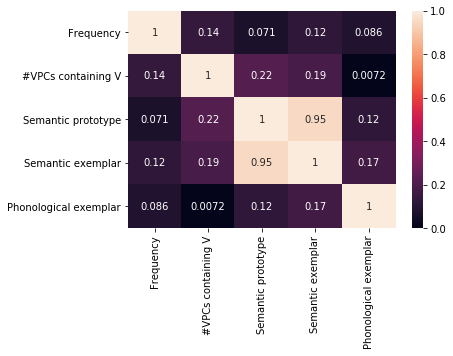

In [16]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ], plot_style="heatmap")

  5%|▌         | 1/19 [00:00<00:04,  3.93it/s]

1810 1 (0.1830621131265955, 0.0)
1810 2 (0.10017163835827633, 1.6046157605542503e-142)
1810 3 (0.14105066831387678, 6.274827030876214e-282)
1810 4 (0.09491176795819495, 4.365994715481842e-128)


 11%|█         | 2/19 [00:00<00:04,  4.14it/s]

1820 1 (0.16190104206480374, 0.0)
1820 2 (0.09375544206528663, 4.165999045982358e-124)
1820 3 (0.13437296284731967, 6.017547813772199e-254)
1820 4 (0.09025733085937662, 3.9818507848564717e-115)
1830 1 (0.16743227370929564, 0.0)


 16%|█▌        | 3/19 [00:00<00:03,  4.33it/s]

1830 2 (0.08504299956305794, 1.1790661237891998e-101)
1830 3 (0.13361149959090715, 2.8306731032142025e-249)
1830 4 (0.09169249875267872, 6.345998780594246e-118)
1840 1 (0.1561592002974837, 0.0)
1840 2 (0.08219047541828498, 2.2318714725617358e-94)


 21%|██        | 4/19 [00:00<00:03,  4.34it/s]

1840 3 (0.13426518204011526, 6.61218502462304e-250)
1840 4 (0.08992071549896596, 1.1729692467238963e-112)
1850 1 (0.15446981566625897, 0.0)
1850 2 (0.08120768820706203, 1.7238432489765175e-91)


 26%|██▋       | 5/19 [00:01<00:03,  4.38it/s]

1850 3 (0.13593234809232332, 3.1068770565898116e-254)
1850 4 (0.09095441522412008, 2.2683236577442563e-114)
1860 1 (0.14995287628471884, 1.6644178493639094e-307)
1860 2 (0.07497447041968595, 1.0119315097385638e-77)


 32%|███▏      | 6/19 [00:01<00:02,  4.45it/s]

1860 3 (0.12769365738286004, 6.972151050080045e-223)
1860 4 (0.09002763323753014, 2.363677398710663e-111)
1870 1 (0.14781496353352325, 5.3487195779820356e-297)
1870 2 (0.07882140567143943, 3.1495131027711663e-85)


 37%|███▋      | 7/19 [00:01<00:02,  4.44it/s]

1870 3 (0.13357029063668174, 2.0321364125271498e-242)
1870 4 (0.09193752772519719, 2.2016225859314767e-115)
1880 1 (0.14027551353523365, 4.364317999564911e-266)
1880 2 (0.07385564547992522, 1.1410895434485478e-74)
1880 3 (0.12947092135101224, 1.1697822057185937e-226)


 42%|████▏     | 8/19 [00:01<00:02,  4.67it/s]

1880 4 (0.08895326578740419, 1.3779044851694595e-107)
1890 1 (0.1371086951927131, 6.331061590495504e-253)
1890 2 (0.0711116442358189, 5.239847872391542e-69)
1890 3 (0.12232343880497534, 2.3222689322369963e-201)


 47%|████▋     | 9/19 [00:01<00:02,  4.67it/s]

1890 4 (0.0891043455051497, 2.047121030560582e-107)
1900 1 (0.134154127509696, 9.831093008810662e-241)
1900 2 (0.06900161266199303, 1.0574118433004052e-64)
1900 3 (0.12231760919110073, 3.5349387682789884e-200)


 53%|█████▎    | 10/19 [00:02<00:01,  4.50it/s]

1900 4 (0.0905550024538136, 2.958268361942776e-110)
1910 1 (0.13060298776718512, 5.734916146380141e-227)
1910 2 (0.06629274069978044, 1.5156860979951278e-59)
1910 3 (0.1213267506705899, 6.265532787862856e-196)


 58%|█████▊    | 11/19 [00:02<00:01,  4.42it/s]

1910 4 (0.08999165977797835, 2.4220990814520063e-108)
1920 1 (0.13139137876763676, 6.081386222357571e-229)
1920 2 (0.06588566570429899, 1.2087789521167808e-58)
1920 3 (0.12310935993637126, 4.922726773200221e-201)


 63%|██████▎   | 12/19 [00:02<00:01,  4.49it/s]

1920 4 (0.0861049350717882, 5.4991148749399305e-99)
1930 1 (0.13004899517781113, 9.3825962419013e-224)
1930 2 (0.06426751341055066, 9.465600499448147e-56)


 68%|██████▊   | 13/19 [00:02<00:01,  4.24it/s]

1930 3 (0.1230624157065286, 2.1187387230824232e-200)
1930 4 (0.08576396890328782, 5.5363695357958594e-98)
1940 1 (0.12884929919200083, 3.103691844886209e-219)
1940 2 (0.06568986510916125, 4.618246677328484e-58)


 74%|███████▎  | 14/19 [00:03<00:01,  4.21it/s]

1940 3 (0.12449364344254601, 1.0894296169959608e-204)
1940 4 (0.0848394561731171, 9.763972259593889e-96)
1950 1 (0.1280763394152639, 2.977491614288034e-216)
1950 2 (0.06455036309274367, 4.95464772656998e-56)


 79%|███████▉  | 15/19 [00:03<00:00,  4.17it/s]

1950 3 (0.12280552039468569, 7.40843920372819e-199)
1950 4 (0.082685120854819, 7.255676656926969e-91)
1960 1 (0.12073795150939595, 6.5624708299498596e-192)
1960 2 (0.057622987686287805, 6.40984480207164e-45)
1960 3 (0.11493169416078952, 5.700527592307298e-174)


 84%|████████▍ | 16/19 [00:03<00:00,  4.06it/s]

1960 4 (0.07906162792227538, 4.481307773169365e-83)
1970 1 (0.11528299596925107, 8.378999544442811e-175)
1970 2 (0.05328831887605685, 1.3055852811622629e-38)
1970 3 (0.10279887786886968, 3.1981936440990937e-139)


 89%|████████▉ | 17/19 [00:03<00:00,  4.01it/s]

1970 4 (0.07650600703255152, 8.513436139421262e-78)
1980 1 (0.11091233666262708, 9.795315488817311e-162)
1980 2 (0.05181090851647992, 1.4644733051815005e-36)
1980 3 (0.10180370051834212, 1.8972863615713284e-136)


 95%|█████████▍| 18/19 [00:04<00:00,  3.96it/s]

1980 4 (0.07334105979049933, 1.4404377150653057e-71)
1990 1 (0.11183431108034639, 2.751491825617262e-164)
1990 2 (0.051686671644601966, 2.295516512146061e-36)
1990 3 (0.09901185947205472, 4.8987206901187036e-129)


100%|██████████| 19/19 [00:04<00:00,  4.06it/s]

1990 4 (0.07226560148013382, 1.7699477647409188e-69)


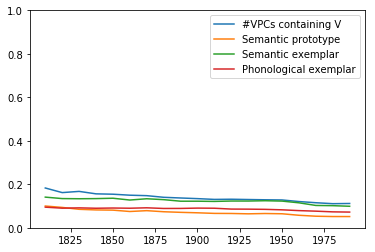

In [17]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])

# Run multiple logistic regressions, to see how the features interact

In [48]:
import numpy as np


def pickle_rankings(
        ranking_functions, output_path="func_to_rankings.pickle",
        start_decade=1810, end_decade=2000):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[ranking_name][year] = curr_ranking
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(dict(func_to_rankings), f)
    return func_to_rankings


func_to_rankings = pickle_rankings([get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])

100%|██████████| 19/19 [00:54<00:00,  2.80s/it]


  0%|          | 0/19 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.034598
         Iterations 11


  5%|▌         | 1/19 [00:01<00:27,  1.53s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64064
Model:                          Logit   Df Residuals:                    64058
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.2092
Time:                        12:12:40   Log-Likelihood:                -2216.5
converged:                       True   LL-Null:                       -2802.8
                                        LLR p-value:                2.564e-251
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.1014      0.096    -63.868      0.000      -6.289      -5.914
Frequency                 0.0560      0.015      3.788      0.000       0.027       0.085
VPC coun

 11%|█         | 2/19 [00:03<00:27,  1.59s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63589
Model:                          Logit   Df Residuals:                    63583
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1772
Time:                        12:12:41   Log-Likelihood:                -2242.6
converged:                       True   LL-Null:                       -2725.7
                                        LLR p-value:                1.362e-206
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9607      0.094    -63.324      0.000      -6.145      -5.776
Frequency                 0.0345      0.016      2.160      0.031       0.003       0.066
VPC coun

 16%|█▌        | 3/19 [00:05<00:26,  1.65s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63129
Model:                          Logit   Df Residuals:                    63123
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1957
Time:                        12:12:43   Log-Likelihood:                -2185.6
converged:                       True   LL-Null:                       -2717.4
                                        LLR p-value:                1.076e-227
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2136      0.109    -57.150      0.000      -6.427      -6.000
Frequency                 0.0415      0.017      2.443      0.015       0.008       0.075
VPC coun

 21%|██        | 4/19 [00:06<00:24,  1.65s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62670
Model:                          Logit   Df Residuals:                    62664
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1759
Time:                        12:12:45   Log-Likelihood:                -2297.1
converged:                       True   LL-Null:                       -2787.4
                                        LLR p-value:                9.529e-210
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.1266      0.108    -56.589      0.000      -6.339      -5.914
Frequency                 0.0396      0.017      2.278      0.023       0.006       0.074
VPC coun

 26%|██▋       | 5/19 [00:08<00:23,  1.66s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62196
Model:                          Logit   Df Residuals:                    62190
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1796
Time:                        12:12:47   Log-Likelihood:                -2032.7
converged:                       True   LL-Null:                       -2477.6
                                        LLR p-value:                4.026e-190
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9871      0.095    -63.277      0.000      -6.173      -5.802
Frequency                 0.0150      0.020      0.756      0.449      -0.024       0.054
VPC coun

 32%|███▏      | 6/19 [00:10<00:21,  1.65s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61784
Model:                          Logit   Df Residuals:                    61778
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1802
Time:                        12:12:48   Log-Likelihood:                -1846.4
converged:                       True   LL-Null:                       -2252.3
                                        LLR p-value:                3.354e-173
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.3299      0.119    -53.310      0.000      -6.563      -6.097
Frequency                 0.0610      0.017      3.641      0.000       0.028       0.094
VPC coun

 37%|███▋      | 7/19 [00:11<00:19,  1.61s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61416
Model:                          Logit   Df Residuals:                    61410
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1620
Time:                        12:12:50   Log-Likelihood:                -1601.9
converged:                       True   LL-Null:                       -1911.7
                                        LLR p-value:                1.232e-131
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.3777      0.124    -51.398      0.000      -6.621      -6.135
Frequency                 0.0426      0.020      2.118      0.034       0.003       0.082
VPC coun

 42%|████▏     | 8/19 [00:13<00:19,  1.74s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61113
Model:                          Logit   Df Residuals:                    61107
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1424
Time:                        12:12:52   Log-Likelihood:                -1656.3
converged:                       True   LL-Null:                       -1931.4
                                        LLR p-value:                1.218e-116
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2761      0.117    -53.534      0.000      -6.506      -6.046
Frequency                 0.0333      0.020      1.643      0.100      -0.006       0.073
VPC coun

 47%|████▋     | 9/19 [00:15<00:17,  1.71s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60806
Model:                          Logit   Df Residuals:                    60800
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1375
Time:                        12:12:53   Log-Likelihood:                -1880.0
converged:                       True   LL-Null:                       -2179.8
                                        LLR p-value:                2.401e-127
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9557      0.094    -63.242      0.000      -6.140      -5.771
Frequency                 0.0526      0.018      2.891      0.004       0.017       0.088
VPC coun

 53%|█████▎    | 10/19 [00:17<00:16,  1.86s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60451
Model:                          Logit   Df Residuals:                    60445
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1424
Time:                        12:12:56   Log-Likelihood:                -1707.5
converged:                       True   LL-Null:                       -1991.1
                                        LLR p-value:                2.531e-120
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2612      0.122    -51.318      0.000      -6.500      -6.022
Frequency                 0.0752      0.016      4.623      0.000       0.043       0.107
VPC coun

 58%|█████▊    | 11/19 [00:19<00:15,  1.92s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60132
Model:                          Logit   Df Residuals:                    60126
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1177
Time:                        12:12:58   Log-Likelihood:                -1203.1
converged:                       True   LL-Null:                       -1363.6
                                        LLR p-value:                 2.938e-67
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.4684      0.122    -53.189      0.000      -6.707      -6.230
Frequency                 0.0705      0.021      3.376      0.001       0.030       0.111
VPC coun

 63%|██████▎   | 12/19 [00:21<00:13,  1.98s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59928
Model:                          Logit   Df Residuals:                    59922
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1151
Time:                        12:13:00   Log-Likelihood:                -901.07
converged:                       True   LL-Null:                       -1018.3
                                        LLR p-value:                 1.154e-48
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.8883      0.154    -44.617      0.000      -7.191      -6.586
Frequency                 0.0580      0.026      2.195      0.028       0.006       0.110
VPC coun

 68%|██████▊   | 13/19 [00:23<00:12,  2.02s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59783
Model:                          Logit   Df Residuals:                    59777
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09879
Time:                        12:13:02   Log-Likelihood:                -746.02
converged:                       True   LL-Null:                       -827.79
                                        LLR p-value:                 1.732e-33
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.9632      0.151    -46.014      0.000      -7.260      -6.667
Frequency                 0.0479      0.035      1.380      0.168      -0.020       0.116
VPC coun

 74%|███████▎  | 14/19 [00:25<00:10,  2.01s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59669
Model:                          Logit   Df Residuals:                    59663
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09820
Time:                        12:13:04   Log-Likelihood:                -672.24
converged:                       True   LL-Null:                       -745.44
                                        LLR p-value:                 7.786e-30
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.0225      0.156    -45.090      0.000      -7.328      -6.717
Frequency                 0.0394      0.035      1.122      0.262      -0.029       0.108
VPC coun

 79%|███████▉  | 15/19 [00:27<00:07,  1.96s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59568
Model:                          Logit   Df Residuals:                    59562
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09345
Time:                        12:13:06   Log-Likelihood:                -687.17
converged:                       True   LL-Null:                       -758.01
                                        LLR p-value:                 7.914e-29
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.1280      0.168    -42.540      0.000      -7.456      -6.800
Frequency                 0.0357      0.036      1.006      0.314      -0.034       0.105
VPC coun

 84%|████████▍ | 16/19 [00:29<00:05,  1.90s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59465
Model:                          Logit   Df Residuals:                    59459
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.08963
Time:                        12:13:08   Log-Likelihood:                -542.21
converged:                       True   LL-Null:                       -595.59
                                        LLR p-value:                 1.974e-21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.3053      0.191    -38.290      0.000      -7.679      -6.931
Frequency                 0.1090      0.022      5.043      0.000       0.067       0.151
VPC coun

 89%|████████▉ | 17/19 [00:31<00:04,  2.01s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59387
Model:                          Logit   Df Residuals:                    59381
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.06644
Time:                        12:13:10   Log-Likelihood:                -383.73
converged:                       True   LL-Null:                       -411.04
                                        LLR p-value:                 1.566e-10
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.6270      0.213    -35.790      0.000      -8.045      -7.209
Frequency                -0.0569      0.127     -0.448      0.654      -0.306       0.192
VPC coun

 95%|█████████▍| 18/19 [00:33<00:01,  1.93s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59336
Model:                          Logit   Df Residuals:                    59330
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.08431
Time:                        12:13:12   Log-Likelihood:                -356.87
converged:                       True   LL-Null:                       -389.73
                                        LLR p-value:                 7.963e-13
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.7356      0.232    -33.279      0.000      -8.191      -7.280
Frequency                 0.1050      0.027      3.865      0.000       0.052       0.158
VPC coun

100%|██████████| 19/19 [00:35<00:00,  2.02s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59288
Model:                          Logit   Df Residuals:                    59282
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.05855
Time:                        12:13:14   Log-Likelihood:                -213.74
converged:                       True   LL-Null:                       -227.03
                                        LLR p-value:                 6.868e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.1852      0.275    -29.781      0.000      -8.724      -7.646
Frequency                 0.0657      0.053      1.237      0.216      -0.038       0.170
VPC coun

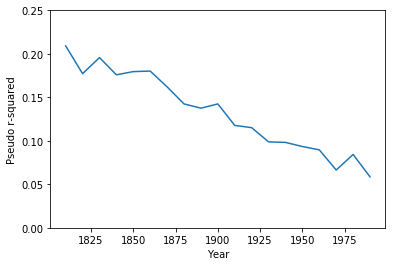

In [52]:
# Multiple regressions -- 
# Features that are consistently significant:
#   * #VPCs containing V 
#   * Nearest neighbors prototype
#   * phonological exemplar
# Features that often come out as non-significant: 
#   * VPCs containing V and 
#   * Nearest neighbors exemplar

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1810
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
feat_to_coeff = defaultdict(list)
feat_to_pval = defaultdict(list)
pseudo_r_squared = []
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
    X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]
         for curr_func in func_to_rankings})
    for feat in func_to_rankings:
        X[feat] = (X[feat] - np.mean(X[feat])) / np.std(X[feat])
        
    X = statsmodels.tools.tools.add_constant(X)
    logit = sm.Logit(y, X)
    result = logit.fit()
    print(result.summary())
    pseudo_r_squared.append(result.prsquared)
    for feat in func_to_rankings:
        feat_to_pval[feat].append(result.pvalues[feat])
        feat_to_coeff[feat].append(result.params[feat])
    known_vpcs.update(novel_vpcs)
    
plt.plot(list(range(start_decade, end_decade, 10)), pseudo_r_squared)
plt.ylim((0, 0.25))
plt.xlabel("Year")
plt.ylabel("Pseudo r-squared")
plt.savefig("pseudo_r_squared.png", dpi=500)

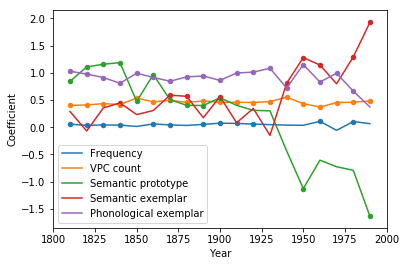

In [61]:
years = list(range(start_decade, end_decade, 10))

feat_to_color={
    "Frequency": "C0",
    "VPC count": "C1",
    "Semantic prototype": "C2",
    "Semantic exemplar": "C3",
    "Phonological exemplar": "C4"
}

for feat, coeffs in feat_to_coeff.items():
    plt.plot(years, coeffs, label=feat, color=feat_to_color[feat])
    for curr_coeff, curr_pval, curr_year in zip(coeffs, feat_to_pval[feat], years):
        if curr_pval < 0.05:
            plt.scatter([curr_year], [curr_coeff], c=feat_to_color[feat], s=20)
    
plt.legend()
plt.ylabel("Coefficient")
plt.xlabel("Year")
plt.savefig("coefficients.png", dpi=500)

In [67]:
# Individual regressions

# All predictors are significant in most decades.
# The following predictors are non-significant in at least one decade:
#    * Nearest neighbors prototype: 2 decades
#    * Nearest neighbors exemplar: 2 decades
#    * Verb Frequency * Prt Frequency: 1 decade

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1810
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    for curr_func in func_to_rankings:
        y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
        X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]})
        X = statsmodels.tools.tools.add_constant(X)
        X[curr_func] = (X[curr_func] - np.mean(X[curr_func])) / np.std(X[curr_func])
        
        logit = sm.Logit(y, X)
        result = logit.fit()
        # print(result.summary())
        print(year, curr_func, result.params[curr_func])
        if result.params[curr_func] < 0:
            raise ValueError()
    known_vpcs.update(novel_vpcs)


  0%|          | 0/19 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.042965
         Iterations 9
1810 Frequency 0.15748979717483777
Optimization terminated successfully.
         Current function value: 0.039044
         Iterations 9
1810 VPC count 0.4633227329523449
Optimization terminated successfully.
         Current function value: 0.039584
         Iterations 10
1810 Semantic prototype 2.132225629967709
Optimization terminated successfully.
         Current function value: 0.040513
         Iterations 10
1810 Semantic exemplar 1.5872294186419316



  5%|▌         | 1/19 [00:02<00:39,  2.18s/it]

Optimization terminated successfully.
         Current function value: 0.040637
         Iterations 10
1810 Phonological exemplar 1.2335605693338494
Optimization terminated successfully.
         Current function value: 0.042516
         Iterations 9
1820 Frequency 0.11739879136364707
Optimization terminated successfully.
         Current function value: 0.038847
         Iterations 9
1820 VPC count 0.4622715870297556
Optimization terminated successfully.
         Current function value: 0.039542
         Iterations 11
1820 Semantic prototype 2.307925124740908
Optimization terminated successfully.
         Current function value: 0.040634
         Iterations 11
1820 Semantic exemplar 1.4751838692161046



 11%|█         | 2/19 [00:05<00:40,  2.39s/it]

Optimization terminated successfully.
         Current function value: 0.040195
         Iterations 10
1820 Phonological exemplar 1.1713472517876335
Optimization terminated successfully.
         Current function value: 0.042604
         Iterations 9
1830 Frequency 0.1272043463285456
Optimization terminated successfully.
         Current function value: 0.038592
         Iterations 9
1830 VPC count 0.4974682547779522
Optimization terminated successfully.
         Current function value: 0.038789
         Iterations 11
1830 Semantic prototype 2.7301062568053633
Optimization terminated successfully.
         Current function value: 0.040105
         Iterations 11
1830 Semantic exemplar 1.9553146578055585



 16%|█▌        | 3/19 [00:07<00:37,  2.37s/it]

Optimization terminated successfully.
         Current function value: 0.040440
         Iterations 10
1830 Phonological exemplar 1.1739384688112338
Optimization terminated successfully.
         Current function value: 0.044155
         Iterations 9
1840 Frequency 0.11257793594658025
Optimization terminated successfully.
         Current function value: 0.040410
         Iterations 9
1840 VPC count 0.4966774747835722
Optimization terminated successfully.
         Current function value: 0.040262
         Iterations 11
1840 Semantic prototype 2.739705671580522
Optimization terminated successfully.
         Current function value: 0.041534
         Iterations 11
1840 Semantic exemplar 1.9434975086839523



 21%|██        | 4/19 [00:09<00:34,  2.30s/it]

Optimization terminated successfully.
         Current function value: 0.042154
         Iterations 10
1840 Phonological exemplar 1.0861943047131584
Optimization terminated successfully.
         Current function value: 0.039620
         Iterations 9
1850 Frequency 0.10273699069974543
Optimization terminated successfully.
         Current function value: 0.035522
         Iterations 9
1850 VPC count 0.5447679814219636
Optimization terminated successfully.
         Current function value: 0.037433
         Iterations 11
1850 Semantic prototype 2.0248411371508106
Optimization terminated successfully.
         Current function value: 0.038075
         Iterations 11
1850 Semantic exemplar 1.3944832995894167



 26%|██▋       | 5/19 [00:11<00:31,  2.23s/it]

Optimization terminated successfully.
         Current function value: 0.037513
         Iterations 10
1850 Phonological exemplar 1.199782574528597
Optimization terminated successfully.
         Current function value: 0.036029
         Iterations 9
1860 Frequency 0.1324815053634831
Optimization terminated successfully.
         Current function value: 0.033043
         Iterations 9
1860 VPC count 0.5325789045540441
Optimization terminated successfully.
         Current function value: 0.033539
         Iterations 11
1860 Semantic prototype 2.3709811088939463
Optimization terminated successfully.
         Current function value: 0.034386
         Iterations 11
1860 Semantic exemplar 1.8281904294240063



 32%|███▏      | 6/19 [00:14<00:29,  2.30s/it]

Optimization terminated successfully.
         Current function value: 0.034135
         Iterations 10
1860 Phonological exemplar 1.1472093286633915
Optimization terminated successfully.
         Current function value: 0.030839
         Iterations 9
1870 Frequency 0.1274939856524434
Optimization terminated successfully.
         Current function value: 0.028289
         Iterations 10
1870 VPC count 0.5424805509321434
Optimization terminated successfully.
         Current function value: 0.029101
         Iterations 11
1870 Semantic prototype 2.2235860902882596
Optimization terminated successfully.
         Current function value: 0.029465
         Iterations 11
1870 Semantic exemplar 1.7894560867222644



 37%|███▋      | 7/19 [00:16<00:29,  2.48s/it]

Optimization terminated successfully.
         Current function value: 0.029469
         Iterations 10
1870 Phonological exemplar 1.057488196167391
Optimization terminated successfully.
         Current function value: 0.031402
         Iterations 9
1880 Frequency 0.10878041128457229
Optimization terminated successfully.
         Current function value: 0.029417
         Iterations 10
1880 VPC count 0.5033821842766929
Optimization terminated successfully.
         Current function value: 0.029832
         Iterations 11
1880 Semantic prototype 1.95274890429086
Optimization terminated successfully.
         Current function value: 0.030049
         Iterations 11
1880 Semantic exemplar 1.655037046938009



 42%|████▏     | 8/19 [00:19<00:27,  2.51s/it]

Optimization terminated successfully.
         Current function value: 0.029738
         Iterations 10
1880 Phonological exemplar 1.1350900006024718
Optimization terminated successfully.
         Current function value: 0.035547
         Iterations 9
1890 Frequency 0.11998087342241534
Optimization terminated successfully.
         Current function value: 0.033314
         Iterations 9
1890 VPC count 0.5123651681055291
Optimization terminated successfully.
         Current function value: 0.034326
         Iterations 11
1890 Semantic prototype 1.4690573021079527
Optimization terminated successfully.
         Current function value: 0.034622
         Iterations 11
1890 Semantic exemplar 1.1870585557442725



 47%|████▋     | 9/19 [00:22<00:25,  2.57s/it]

Optimization terminated successfully.
         Current function value: 0.033771
         Iterations 10
1890 Phonological exemplar 1.1137896293636422
Optimization terminated successfully.
         Current function value: 0.032535
         Iterations 9
1900 Frequency 0.13893705007786034
Optimization terminated successfully.
         Current function value: 0.030713
         Iterations 10
1900 VPC count 0.5148891550214048
Optimization terminated successfully.
         Current function value: 0.031062
         Iterations 11
1900 Semantic prototype 1.8823294075372605
Optimization terminated successfully.
         Current function value: 0.031255
         Iterations 11
1900 Semantic exemplar 1.8187018927125365



 53%|█████▎    | 10/19 [00:24<00:23,  2.58s/it]

Optimization terminated successfully.
         Current function value: 0.031125
         Iterations 10
1900 Phonological exemplar 1.099754829792727
Optimization terminated successfully.
         Current function value: 0.022482
         Iterations 10
1910 Frequency 0.12398602450138589
Optimization terminated successfully.
         Current function value: 0.021447
         Iterations 10
1910 VPC count 0.4927452837444718
Optimization terminated successfully.
         Current function value: 0.021913
         Iterations 11
1910 Semantic prototype 1.2911150849794581
Optimization terminated successfully.
         Current function value: 0.022042
         Iterations 11
1910 Semantic exemplar 1.109378351901655



 58%|█████▊    | 11/19 [00:27<00:21,  2.71s/it]

Optimization terminated successfully.
         Current function value: 0.021396
         Iterations 11
1910 Phonological exemplar 1.176000318910546
Optimization terminated successfully.
         Current function value: 0.016881
         Iterations 10
1920 Frequency 0.11406915966894628
Optimization terminated successfully.
         Current function value: 0.016121
         Iterations 10
1920 VPC count 0.4957786595013372
Optimization terminated successfully.
         Current function value: 0.016364
         Iterations 12
1920 Semantic prototype 1.483468887020907
Optimization terminated successfully.
         Current function value: 0.016428
         Iterations 12
1920 Semantic exemplar 1.3443619898066954



 63%|██████▎   | 12/19 [00:30<00:19,  2.73s/it]

Optimization terminated successfully.
         Current function value: 0.016039
         Iterations 11
1920 Phonological exemplar 1.214071049346273
Optimization terminated successfully.
         Current function value: 0.013796
         Iterations 10
1930 Frequency 0.09631953272554891
Optimization terminated successfully.
         Current function value: 0.013228
         Iterations 11
1930 VPC count 0.4809083238591375
Optimization terminated successfully.
         Current function value: 0.013616
         Iterations 12
1930 Semantic prototype 0.7541474419681824
Optimization terminated successfully.
         Current function value: 0.013669
         Iterations 11
1930 Semantic exemplar 0.6066166493997857



 68%|██████▊   | 13/19 [00:33<00:16,  2.78s/it]

Optimization terminated successfully.
         Current function value: 0.013089
         Iterations 11
1930 Phonological exemplar 1.2254425216997389
Optimization terminated successfully.
         Current function value: 0.012427
         Iterations 10
1940 Frequency 0.10550545380198247
Optimization terminated successfully.
         Current function value: 0.011753
         Iterations 11
1940 VPC count 0.5340765089044217
Optimization terminated successfully.
         Current function value: 0.012240
         Iterations 12
1940 Semantic prototype 0.9019888475557866
Optimization terminated successfully.
         Current function value: 0.012182
         Iterations 12
1940 Semantic exemplar 1.061273233129873



 74%|███████▎  | 14/19 [00:36<00:14,  2.84s/it]

Optimization terminated successfully.
         Current function value: 0.012108
         Iterations 11
1940 Phonological exemplar 0.8661553152978316
Optimization terminated successfully.
         Current function value: 0.012653
         Iterations 10
1950 Frequency 0.1135759568824801
Optimization terminated successfully.
         Current function value: 0.012384
         Iterations 11
1950 VPC count 0.40862029197422095
Optimization terminated successfully.
         Current function value: 0.012626
         Iterations 11
1950 Semantic prototype 0.43666639829866627
Optimization terminated successfully.
         Current function value: 0.012493
         Iterations 12
1950 Semantic exemplar 0.8033551268698494



 79%|███████▉  | 15/19 [00:39<00:11,  2.83s/it]

Optimization terminated successfully.
         Current function value: 0.012020
         Iterations 12
1950 Phonological exemplar 1.2525010677514896
Optimization terminated successfully.
         Current function value: 0.009754
         Iterations 11
1960 Frequency 0.16231818243975785
Optimization terminated successfully.
         Current function value: 0.009760
         Iterations 11
1960 VPC count 0.4088233215169995
Optimization terminated successfully.
         Current function value: 0.009862
         Iterations 12
1960 Semantic prototype 0.7300416231638805
Optimization terminated successfully.
         Current function value: 0.009722
         Iterations 13
1960 Semantic exemplar 1.32351499267017



 84%|████████▍ | 16/19 [00:41<00:08,  2.71s/it]

Optimization terminated successfully.
         Current function value: 0.009641
         Iterations 12
1960 Phonological exemplar 1.0011768006408133
Optimization terminated successfully.
         Current function value: 0.006918
         Iterations 11
1970 Frequency 0.05739304807017388
Optimization terminated successfully.
         Current function value: 0.006750
         Iterations 11
1970 VPC count 0.413000076111622
Optimization terminated successfully.
         Current function value: 0.006883
         Iterations 12
1970 Semantic prototype 0.3640876454095964
Optimization terminated successfully.
         Current function value: 0.006867
         Iterations 12
1970 Semantic exemplar 0.4591371989175909



 89%|████████▉ | 17/19 [00:44<00:05,  2.60s/it]

Optimization terminated successfully.
         Current function value: 0.006641
         Iterations 12
1970 Phonological exemplar 1.0921575356004458
Optimization terminated successfully.
         Current function value: 0.006410
         Iterations 11
1980 Frequency 0.16166223781168598
Optimization terminated successfully.
         Current function value: 0.006359
         Iterations 11
1980 VPC count 0.45328183653920745
Optimization terminated successfully.
         Current function value: 0.006482
         Iterations 12
1980 Semantic prototype 0.6715364356833631
Optimization terminated successfully.
         Current function value: 0.006410
         Iterations 13
1980 Semantic exemplar 1.165877894557424



 95%|█████████▍| 18/19 [00:47<00:02,  2.72s/it]

Optimization terminated successfully.
         Current function value: 0.006394
         Iterations 12
1980 Phonological exemplar 0.8434555160708257
Optimization terminated successfully.
         Current function value: 0.003792
         Iterations 12
1990 Frequency 0.14030986489958364
Optimization terminated successfully.
         Current function value: 0.003746
         Iterations 12
1990 VPC count 0.4076581100519544
Optimization terminated successfully.
         Current function value: 0.003809
         Iterations 12
1990 Semantic prototype 0.3733368060222699
Optimization terminated successfully.
         Current function value: 0.003769
         Iterations 13
1990 Semantic exemplar 0.8463933076808763



100%|██████████| 19/19 [00:49<00:00,  2.65s/it]


Optimization terminated successfully.
         Current function value: 0.003787
         Iterations 12
1990 Phonological exemplar 0.5252403019796272


In [66]:
raise ValueErrorueError()

NameError: name 'ValueErrorueError' is not defined